# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pymystem3 import Mystem
from collections import Counter
pd.set_option('display.max_columns', None)

Прочитаем данные, посмотрим информацию о нем через head(), info(), describe()

In [196]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') 
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [197]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Что настораживает - максимальные значения нереальные, будем исправлять или избавляться.
    

In [198]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

Много некорректных, отсутствующих данных. 
Надо изменить названия столбцов на более удобные. 


### Шаг 2. Предобработка данных

Посчитаем количество пропущенных значений

In [199]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

1.  ceiling_height      - пропущенные значения заменим на средние
2.  floors_total        - Уберем строки, где не указана высотность дома.
3.  living_area         - здесь можно заполнить средней жилой площадью.
4.  is_apartment        - заменим на 0
5.  kitchen_area        - также вставим среднюю площадь кухни
6.  balcony             - заменим на 0, если не указывали, то балкона нет.
7.  locality_name       - можно удалить, поскольку анализировать без привязки к населенному пункту невозможно. Да и количество не сильно повлияет на общую картину.
8.  airports_nearest    - заменим на 0, т.к. нет возможности поставить корректные данные
9.  cityCenters_nearest - заменим на 0, т.к. нет возможности поставить корректные данные
10. parks_around3000    - заменим на 0, т.к. нет возможности поставить корректные данные
11. parks_nearest       - заменим на 0, т.к. нет возможности поставить корректные данные
12. ponds_around3000    - заменим на 0, т.к. нет возможности поставить корректные данные
13. ponds_nearest       - заменим на 0, т.к. нет возможности поставить корректные данные
14. days_exposition     - пропуск означает, что объявление актуально. Заменим на 0, который будем считать актуальным.

Убираем пропуски days_exposition и поменяем тип данных

In [200]:
data['days_exposition'] = data['days_exposition'].fillna(0).astype('int')

Причина пропуска не понятна, пока оставлям.

In [201]:
data['locality_name'].value_counts()

Санкт-Петербург                                      15721
посёлок Мурино                                         522
посёлок Шушары                                         440
Всеволожск                                             398
Пушкин                                                 369
                                                     ...  
посёлок при железнодорожной станции Вещево               1
поселок станции Корнево                                  1
деревня Шпаньково                                        1
поселок Цвылёво                                          1
посёлок при железнодорожной станции Приветнинское        1
Name: locality_name, Length: 364, dtype: int64

В случайной выборке видим значения равные 20, 26, 32 - предполагаю, что это ошибка при заполнении и нужно передвинуть десятичный знак влево. Все значения больше 10 разделим на 10.
Также изменим минимальное значение равное 1, добавим еще 1 метр к высоте. А остальные от 6 до 10 метров уменьшим до 6.
Сделаем это через функцию. И применим ее к столбцу.

В столбце с датой убираем время.

In [202]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')

Пропуски в балконах меняем на 0. Считаем, что там где не указаны балконы, там их нет. Меняем значение на целочисленное.

In [203]:
data['balcony'].value_counts()
data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].astype('int')

Высоту потолков пока не трогаю. Есть очень большие значения, но они не сильно влияют на общую картину. 

В столбце "is_apartment" пропущенные значения меняем на False

In [204]:
data['is_apartment'] = data['is_apartment'].fillna(False)

Для удобства переведем цену и общую площадь в "int"

In [205]:
data['last_price'] = data['last_price'].astype('int')
data['total_area'] = data['total_area'].astype('int')

Избавимся от пропущеных значений в остальных столбцах.

In [206]:
data['is_apartment']        = data['is_apartment'].fillna(0)
data['airports_nearest']    = data['airports_nearest'].fillna(0)
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(0)
data['parks_around3000']    = data['parks_around3000'].fillna(0)
data['parks_nearest']       = data['parks_nearest'].fillna(0)
data['ponds_nearest']       = data['ponds_nearest'].fillna(0)

### Шаг 3. Посчитайте и добавьте в таблицу

Добавим:
1. Цена квадратного метра;
2. День недели, месяц и год публикации объявления;
3. Этаж квартиры; варианты — первый, последний, другой;
4. Соотношение жилой и общей площади, а также отношение площади кухни к общей.

1. Посчитаем цену квадратного метра
2. Добавим в таблицу столбцы дня недели, месяца и года

In [207]:
data['price_square_meter'] = data['last_price'] / data['total_area']
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

Функция для категоризации этажа.
Добавим категорию каждой строке.

In [208]:
def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif 1 < floor < floors_total:
        return 'другой'

data['floor_category'] = data.apply(floor_category, axis = 1)

Теперь вычислим отношения площадей комнат и кухни к общей площади.

In [209]:
data['use_ratio'] = data['living_area'] / data['total_area']
data['kitchen_ratio'] = data['kitchen_area'] / data['total_area']

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

Напишем функцию для отрисовки гистограмм.

Посмотрим на общую площадь. Выбросы есть, но они не сильно влияют на общую картину.

count    22886.000000
mean        57.062484
std         25.411923
min         12.000000
25%         40.000000
50%         51.000000
75%         67.000000
max        200.000000
Name: total_area, dtype: float64

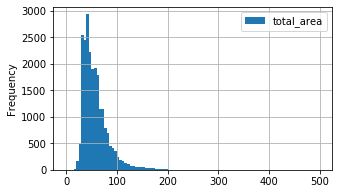

In [267]:
ploto('total_area', 100, (5,3), (0, 500))
data['total_area'].describe()

Общая картина по ценам, комнатам и выоте потолков нормальная.
Цены на недвижимость имеют среднее значение в 6,5 млн руб., медиана 4,6 млн руб.

count    2.288600e+04
mean     5.525999e+06
std      3.628697e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.550000e+06
75%      6.500000e+06
max      3.719989e+07
Name: last_price, dtype: float64

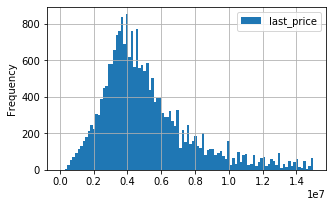

In [260]:
ploto('last_price', 100, (5,3), (0,15000000))
data['last_price'].describe()

Количество комнат колеблется от 1 до 19. Больше всего однокомнатных квартир.

count    22886.000000
mean         2.024644
std          0.992348
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: rooms, dtype: float64

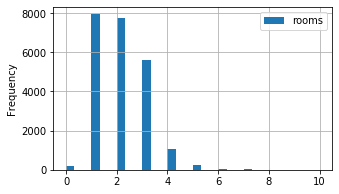

In [270]:
ploto('rooms', 30, (5,3), (0,10))
#data.plot(y = 'rooms', kind = 'hist', bins = 30, grid=True, figsize = (5,3))
data['rooms'].describe()

Высота потолков в среднем составляет 2,77 м, медиана 2,65 м.

count    13958.000000
mean         2.707192
std          0.244186
min          1.000000
25%          2.500000
50%          2.650000
75%          2.800000
max          4.000000
Name: ceiling_height, dtype: float64

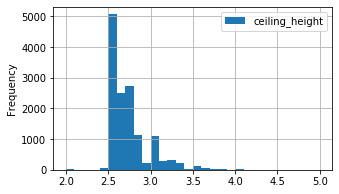

In [272]:
ploto('ceiling_height', 30, (5,3), (2,5))
#data.plot(y = 'ceiling_height', kind = 'hist', bins = 30, range = (2,5), grid=True, figsize = (5,3))
data['ceiling_height'].describe()

Во всех данных есть значения, которые надо заменить, либо удалить, наподобе 0 комнат, высоты потолков в 1 или 100 метров, а также цена квартиры в 12190 рублей. Не станем убирать эти выбивающиеся значения, о причинах их появления нужно уточнить у сотрудников, предоставивших данные.

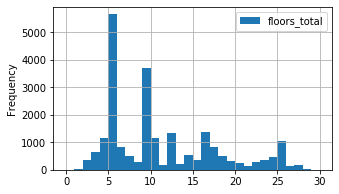

In [273]:
ploto('floors_total', 30, (5,3), (0, 30))
#data.plot(y = 'floors_total', kind = 'hist', bins = 30, grid=True, figsize = (5,3))

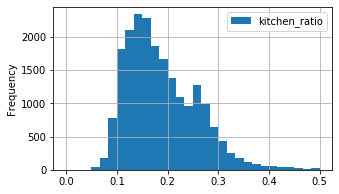

In [275]:
ploto('kitchen_ratio', 30, (5,3), (0, 0.5))
#data.plot(y = 'kitchen_ratio', kind = 'hist', bins = 30, grid=True, figsize = (5,3))

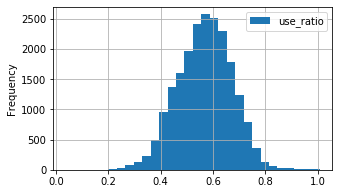

In [246]:
ploto('use_ratio', 30, (5,3), (0, 1))
#data.plot(y = 'use_ratio', kind = 'hist', bins = 30, grid=True, figsize = (5,3))

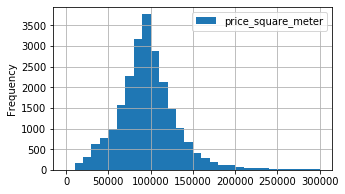

In [243]:
ploto('price_square_meter', 30, (5,3), (0, 300000))
#data.plot(y = 'price_square_meter', kind = 'hist', bins = 30, grid=True, figsize = (5,3))

Из анализа распределения следует наличие выбросов в столбцах:
с высотой потолка - более 4-х метров
с количеством этажей - более 30 этажей
долю кухни в общей площади - более 0,5
долю жилой площади - меньше 0,2 и больше 0,85
полную площадь, более 200 кв.метров
ценой за квадратный метр - более 200 тыс.руб/кв.метр

Удалим выбросы

In [244]:
data.drop(data.query('floors_total > 30').index, inplace=True)
data.drop(data.query('kitchen_ratio > 0.5').index, inplace=True)
data.drop(data.query('0.2 > use_ratio > 0.85').index, inplace=True)
data.drop(data.query('ceiling_height > 4.0').index, inplace=True) 
data.drop(data.query('total_area > 200').index, inplace=True)
data.drop(data.query('price_square_meter > 200000').index, inplace=True)

In [245]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,weekday,month,year,use_ratio,kitchen_ratio,cityCenters_nearest_km
count,22886.000000,2.288600e+04,22886.000000,22886.000000,13958.000000,22801.000000,21064.000000,22886.000000,20701.000000,22886.000000,22886.000000,22886.000000,22886.000000,22886.000000,17411.000000,22886.000000,22886.000000,22886.000000,22886.000000,22886.000000,22886.000000,21064.000000,20701.000000,22886.000000
mean,9.780477,5.525999e+06,57.062484,2.024644,2.707192,10.717600,32.857075,5.896094,10.128331,0.592764,21962.728742,11019.695316,0.445949,162.640523,0.738499,196.584812,155.120554,95020.787209,2.567945,6.402648,2017.373460,0.568238,0.187619,10.642445
std,5.638367,3.628697e+06,25.411923,0.992348,0.244186,6.561546,16.895086,4.881031,4.739316,0.957898,16631.170795,9696.133944,0.725172,303.466583,0.912369,305.535336,211.173572,31433.216931,1.790391,3.489718,1.033776,0.103886,0.069558,9.563904
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,111.834862,0.000000,1.000000,2014.000000,0.038462,0.025381,0.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.500000,5.000000,18.500000,2.000000,7.000000,0.000000,9731.000000,1931.500000,0.000000,0.000000,0.000000,0.000000,23.000000,76315.789474,1.000000,3.000000,2017.000000,0.500000,0.134524,1.000000
50%,9.000000,4.550000e+06,51.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,21536.000000,11485.500000,0.000000,0.000000,0.000000,0.000000,73.000000,94565.217391,3.000000,6.000000,2017.000000,0.571429,0.173333,11.000000
75%,14.000000,6.500000e+06,67.000000,3.000000,2.800000,16.000000,41.900000,8.000000,11.550000,1.000000,34676.000000,15372.000000,1.000000,285.000000,1.000000,380.000000,196.000000,112857.142857,4.000000,10.000000,2018.000000,0.640741,0.233333,15.000000
max,50.000000,3.719989e+07,200.000000,11.000000,4.000000,29.000000,164.700000,27.000000,65.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,200000.000000,6.000000,12.000000,2019.000000,1.008333,0.500000,65.000000


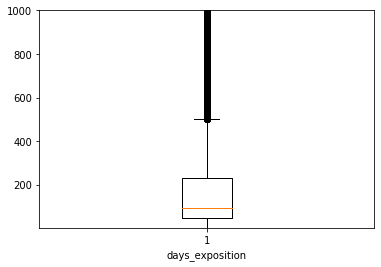

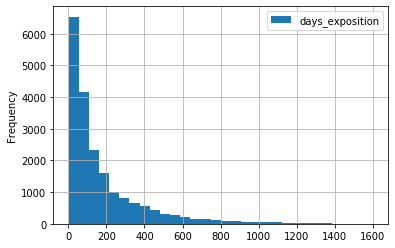

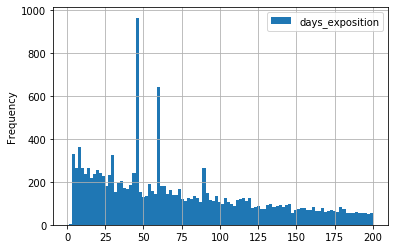

In [277]:
plt.boxplot(data[data['days_exposition']!=0]['days_exposition'])
plt.ylim(1,1000)
plt.xlabel('days_exposition')

ploto('days_exposition', 30, (6, 4), (1,1600))
#data.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,1600))
ploto('days_exposition', 30, (6, 4), (1,200))
#data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,200))

Мы имеем распределение Пуассона. Среднее значение - 180 дней, а медиана - 95 дней. На гистограмме со значениями от 0 до 200 с кол-вом корзин 100, обнаруживаем выбивающиеся значения - у нас аномалии на 30, 45, 60, 90 днях - это наиболее популярное количество дней до снятия объявления. Возможно в эти дни объявление снимается автоматически. Считаю, что нужно убирать эти значения как аномальные.
Судя по диаграмме размаха (метод boxplot) нормальные значения у нас от 1 до 500

Избавляемся от аномалий. И запишем новые данные в good_data

In [221]:
good_data = data.query('days_exposition != 45 and days_exposition != 30 and days_exposition != 60 \
                        and days_exposition != 90 and days_exposition != 0')

Text(0.5, 0, 'good data days_exposition')

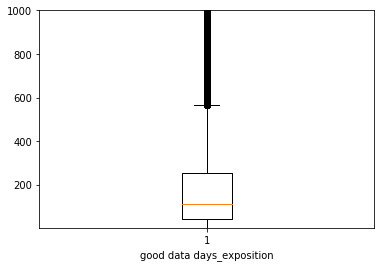

In [222]:
plt.boxplot(good_data['days_exposition'])
plt.ylim(1,1000)
plt.xlabel('good data days_exposition')

count    18326.000000
mean       191.778293
std        224.504403
min          1.000000
25%         43.000000
50%        111.000000
75%        252.000000
max       1580.000000
Name: days_exposition, dtype: float64

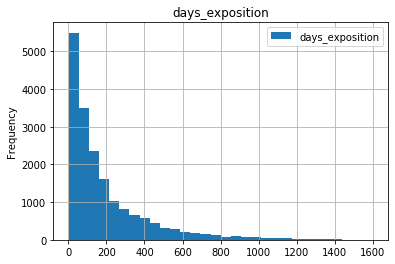

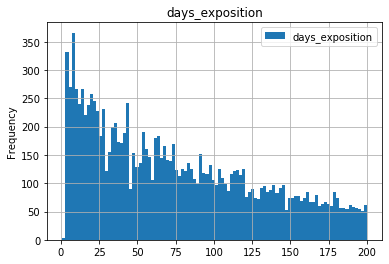

In [279]:
good_data.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,1600))
plt.title('days_exposition')
good_data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,200))
plt.title('days_exposition')
good_data['days_exposition'].describe()

Вывод: ожидаемо, в очищенных данных с аномалиями в значениях меньших медианы получаем бОльшие значения медианы и среднего значения - 112 и 193 соответственно, вместо 95 и 180. Аналогично, теперь нормальные значения располагаются от 1 до 600 дней вместо от 1 до 500 дней.

Какие факторы больше всего влияют на стоимость квартиры?
Рассмотрим зависимость цены от общей площади квартиры.

0.19279126434579166

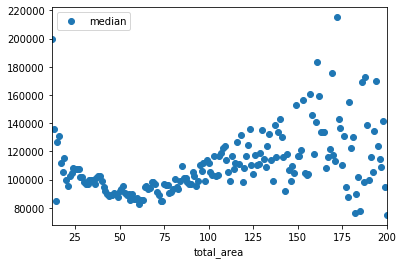

In [224]:
pivot_table_total_area = data.pivot_table(index = 'total_area', values = 'price_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')

pivot_table_total_area.sort_values('median', ascending = False)

data['total_area'].corr(data['price_square_meter'])

Зависимость слабая всего 0,3. Чем меньше площадь квартиры, тем сильнее вырастает стоимоть квадратного метра.

Теперь рассмотрим зависимость стоимости квартиры от числа комнат в квартире.

0.4952103324809264

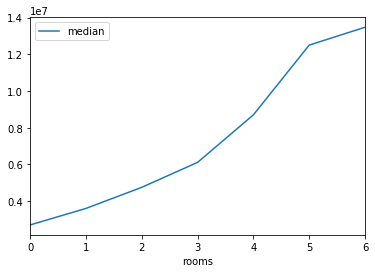

In [225]:
pivot_table_rooms = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_rooms.columns = ['mean', 'count', 'median']
pivot_table_rooms.query('count > 50').plot(y = 'median')
pivot_table_rooms.query('count > 50').sort_values('median', ascending = False)
data['rooms'].corr(data['last_price'])

С ростом числа комнат, растет и стоимость квартиры. Но зависимоcть не очень сильная. Похоже, что тут вмешиваются какие-то дополнительные факторы. Возможно местонахождение квартиры, либо качество дома.

В задании говорится про цену квадратного метра, а не квартиры (((

Теперь посмотрим, как зависит цена от удаленности от центра.

0.10678887653993463

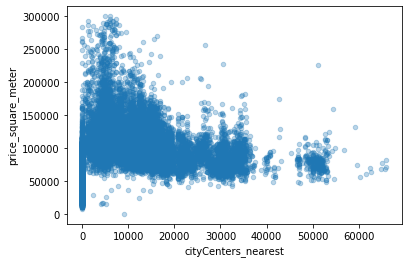

In [226]:
data.plot(kind = 'scatter', y = 'price_square_meter', x = 'cityCenters_nearest', alpha = 0.3)
data['cityCenters_nearest'].corr(data['price_square_meter'])

Здесь явная зависимость. Чем ближе к центру, тем дороже квадратный метр.

Цена квадратного метра от даты размещения (день недели)

,mean,count,median
weekday,,,
2,97464.107584,3887,95744.680851
1,97173.498436,4102,95652.173913
3,96885.414116,4180,95121.951220
0,97323.858544,3542,94899.487584
4,96783.351490,3915,94625.000000
6,96074.735924,1671,94594.594595
5,95360.644161,1896,93548.387097


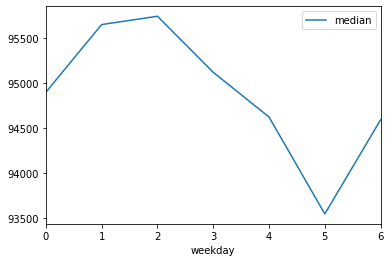

In [227]:
pivot_table_weekday = data.pivot_table(index = 'weekday', values = 'price_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_weekday.columns = ['mean', 'count', 'median']
pivot_table_weekday.plot(y = 'median')
pivot_table_weekday.sort_values('median', ascending = False)

Видно, что максимальная цена приходится на вторник, минимальная на субботу.
С чем это связано? Подозреваю, что размещая объявление во вторник люди надеются на то, что покупатели
максимально активны в плане поиска жилья. Точно так же к субботе активность снижается, люди расслабляются после 
трудовой недели.

Цена квадратного метра от даты размещения (месяц)

,mean,count,median
month,,,
4,98375.110726,2332,96690.476190
8,97449.255374,1707,96052.631579
9,97888.625438,1940,95827.114428
11,97507.861171,2320,95625.000000
1,97671.500279,1465,95500.000000
3,97067.076994,2533,95454.545455
2,96643.778310,2586,95000.000000
7,96548.401391,1654,95000.000000
10,96477.908117,2092,94354.212860


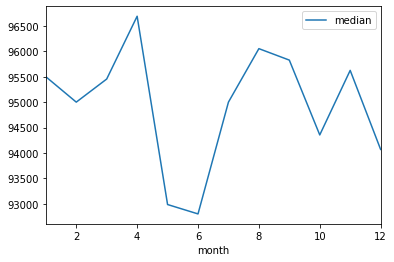

In [228]:
pivot_table_month = data.pivot_table(index = 'month', values = 'price_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_month.columns = ['mean', 'count', 'median']
pivot_table_month.plot(y = 'median')
pivot_table_month.sort_values('median', ascending = False)

Максимальная цена приходится на апрель и на август. Минимальная на май-июнь. 
Продавцы стремятся ка можно быстрее продать квартиры и снижают цены ближе к лету, т.к. спрос падает в связи с началом курортного сезона. Пик продаж приходится на апрель - пришло тепло и есть прекрасная возможность успеть сделать ремонт в новоприобретенной квартире до холодов, отсюда и спрос. Август популярен тем, что покупатель отдохнул, съездил на моря и готов вкалывать в новом жилье.

Цена квадратного метра в зависимости от года.

,mean,count,median
year,,,
2014,114057.491071,129,106400.000000
2019,104512.729340,2818,103632.546981
2018,96499.708241,8384,96052.631579
2015,98307.588307,1142,92705.099778
2017,94945.258753,8008,92592.592593
2016,94590.546244,2712,91506.355204


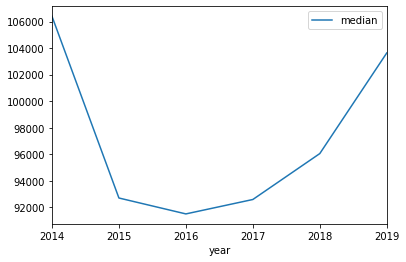

In [229]:
pivot_table_year = data.pivot_table(index = 'year', values = 'price_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_year.columns = ['mean', 'count', 'median']
pivot_table_year.plot(y = 'median')
pivot_table_year.sort_values('median', ascending = False)

Вывод: недвижимость всегда будет расти в цене. Только и она зависит от сотояния экономики. Что мы и видим на диаграмме. 2014-2016 года - достаточно трудные (можно сказать, сказать кризисные), вот и цены на недвижимость отреагировали на это соответственно.

    Выберем 10 населенных пунктов с самым большим количеством объявлений. И посмотрим, что там с ценообразованием.

In [230]:
locality_pivot_table = data.pivot_table(index = 'locality_name', values = 'price_square_meter', aggfunc=['count', 'mean'])
locality_pivot_table.columns = ['count', 'mean']
locality_pivot_table = locality_pivot_table.sort_values('count', ascending = False).head(10)
locality_pivot_table

locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].max()]

,count,mean
locality_name,,
Санкт-Петербург,15266,111263.781267


In [231]:
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].min()]

,count,mean
locality_name,,
Выборг,235,58261.694891


В среднем, максимальная цена за квадратный метр в Снкт-Петербурге, минимальная в Выборге.

    Выясняем, какая область входит в центр. Создадим столбец с расстоянием до центра в километрах. Посчитаем среднюю цену для каждого километра.

,price_square_meter
cityCenters_nearest_km,
0,136877.702192
1,131662.875298
2,121526.345483
3,120397.980614
4,132095.468343
5,133825.340325
6,136916.512221
7,128918.696975
8,119350.390731


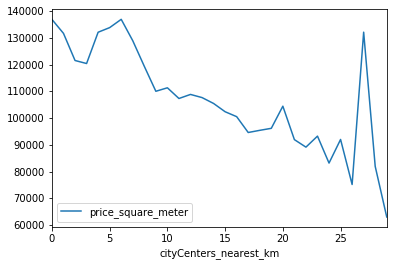

In [232]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest']/1000
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].dropna()
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].astype('int')
pivot_table_km = data.query('locality_name == "Санкт-Петербург"').pivot_table(index = 'cityCenters_nearest_km', values = 'price_square_meter', aggfunc = 'mean')
pivot_table_km.plot()
pivot_table_km

Вывод: Судя по графику - центр это радиус в 3 км.

Выделим квартиры в центре, радиусом 3 км.

In [233]:
center_spb_data = data.query('cityCenters_nearest_km <= 3 and locality_name == "Санкт-Петербург"')

    Посмотрим зависимость стоимости квадратного метра от количества комнат в центре Санкт-Петербурга.

-0.20438745719364768

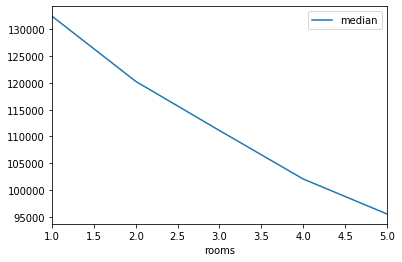

In [234]:
center_spb_rooms = center_spb_data.pivot_table(index = 'rooms', values = 'price_square_meter', aggfunc = ['mean', 'count', 'median'])
center_spb_rooms.columns = ['mean', 'count', 'median']
center_spb_rooms.query('count > 50').plot(y = 'median')

center_spb_rooms.query('count > 50').sort_values('median', ascending = False)

center_spb_data['rooms'].corr(center_spb_data['price_square_meter'])

Судя по графику, в центре стоимость квадратного метра обратно пропорциональна количеству комнат. 
Хотя коэффициент корреляции призывает относится к этому выводу осторожно.

    Проверим зависимость стоимости квадратного метра от этажа.

,mean,count,median
floor_category,,,
другой,128122.400191,690,117441.304348
первый,115128.421536,157,106170.212766
последний,121122.831966,245,111111.111111


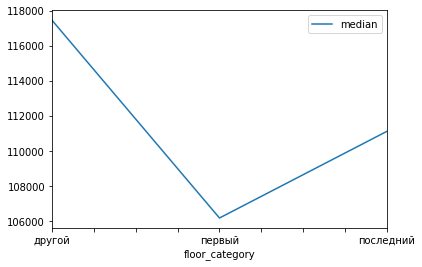

In [235]:
center_spb_floor_category = center_spb_data.pivot_table(index = 'floor_category', values = 'price_square_meter', aggfunc = ['mean', 'count', 'median'])
center_spb_floor_category.columns = ['mean', 'count', 'median']
center_spb_floor_category.plot(y = 'median')
center_spb_floor_category

Так же как и везде, первый этаж стоит дешевле всех ,а самые дорогие посередине.

    Как меняется стоимость квадратного метра по мере удаленности от центра.

-0.14826990046228797

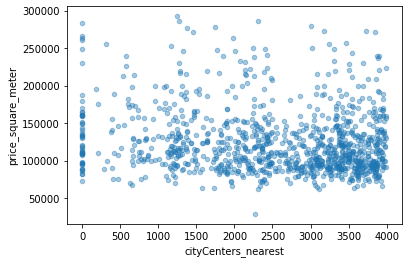

In [236]:
center_spb_data.plot(kind = 'scatter', y = 'price_square_meter', x = 'cityCenters_nearest', alpha = 0.4)
center_spb_data['cityCenters_nearest'].corr(center_spb_data['price_square_meter'])

    Как зависит стоимость от дня размещения объявления.

,mean,count,median
weekday,,,
5,127089.586868,74,121180.780004
0,128038.333703,163,118556.701031
2,131514.750002,189,116981.132075
4,122221.462115,198,115653.357532
1,123694.351764,176,112320.512821
6,129942.371712,69,110843.373494
3,116904.794655,226,108027.777778


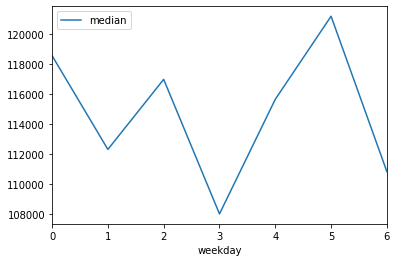

In [237]:
center_spb_weekday = center_spb_data.pivot_table(index = 'weekday', values = 'price_square_meter', aggfunc = ['mean', 'count', 'median'])
center_spb_weekday.columns = ['mean', 'count', 'median']
center_spb_weekday.plot(y = 'median')

center_spb_weekday.sort_values('median', ascending = False)

В отличие от общей выборки, ситуация поменялась. Минимальные средние цены в четверг и воскресенье, самые высокие - в понедельник и субботу!

    Как зависит стоимость от месяца размещения объявления.

,mean,count,median
month,,,
10,129065.072166,88,122233.220489
12,130819.160599,81,121590.909091
3,122423.523316,115,116216.216216
4,126877.325394,113,116119.402985
9,120313.974218,90,114561.403509
2,125150.279871,125,113793.103448
1,130526.033388,70,112097.101449
11,122223.060270,111,112000.000000
6,126847.310923,81,110000.000000


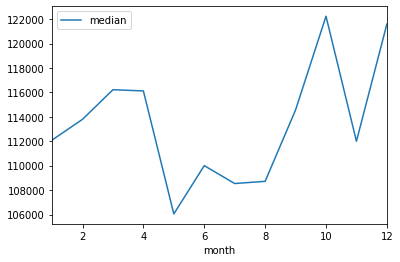

In [238]:
center_spb_month = center_spb_data.pivot_table(index = 'month', values = 'price_square_meter', aggfunc = ['mean', 'count', 'median'])
center_spb_month.columns = ['mean', 'count', 'median']
center_spb_month.plot(y = 'median')

center_spb_month.sort_values('median', ascending = False)

В целом похоже на общую картину - максимум в апреле и августе, минимум в мае.

    Теперь посмотрим зависимось от года размещения объявления.

,mean,count,median
year,,,
2019,132002.730305,145,123622.047244
2018,129305.416472,323,118196.721311
2017,120997.372647,384,112097.560976
2016,120279.768227,137,106122.448980
2015,117297.607654,101,100000.000000


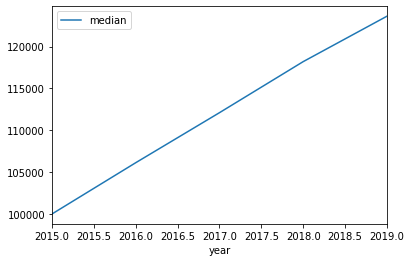

In [239]:
center_spb_year = center_spb_data.pivot_table(index = 'year', values = 'price_square_meter', aggfunc = ['mean', 'count', 'median'])
center_spb_year.columns = ['mean', 'count', 'median']
center_spb_year.query('count > 50').plot(y = 'median')

center_spb_year.query('count > 50').sort_values('median', ascending = False)

В отличие от области, стоимость недвижимости в Питере не падала, а все время росла.

### Шаг 5. Общий вывод

Были обработаны пропущенные значения там, где это необходимо, заменены типы данных на необходимые для удобной работы. Посчитаны и добавлены в таблицу цену квадратного метра жилья, выведены из даты дни недели, месяцы и года размещения объявлений, добавлены категории по этажам квартир. Я изучил следующие параметры на наличие выбивающихся значений - площадь, цена, число комнат, высота потолков. Были определены аномалии в данных параметрах. Изучая время продажи квартир, я выявил, что большое количество объявлений было автоматически снято с Яндекс Недвижимость и дату из снятия нельзя считать датой продажи квартиры, поэтому, изучая средние сроки продажи квартир - данные значения не учитывались. Выявлено при помощи диаграммы размаха, что нормальные значения продажи квартир варьируются от 1 до 600 дней. На стоимость квадратного метра квартиры больше всего влияют количество комнат, этаж квартиры, близость к центру. Незначительно на стоимость квадратного метра влияют день, месяц, год размещения и общая площадь. Нужно учитывать, что в 2016-2017 годах стоимость квартир в среднем по рынку была ниже на 10-20 %, тогда как в центре Санкт-Петербурга данной зависимости от года не обнаружено. В данном случае имело место постоянное удорожание стоимости, начиная с 2015 года по текущий момент. Судя, по резкости изменения цен в зависимости от удаления от центра СПБ, выявился центр города в радиусе 3 километров.

Также важно учитывать, что, рассматривая среднюю стоимость квартир в 2014-2019 годах, не делал сегментацию рынка, а лишь смотрел средние показатели по рынку в целом. Т.е. возможно, что цены на аналогичные квартиры в разных годах вели себя абсолютно по-разному. Т.е. например в то время, когда средняя стоимость метра по рынку в 2016-2017 годах была наиболее низкой, какие-то аналогичные прошлым годам квартиры могли и не падать в цене, а наоборот дорожать! Именно об этом нам и говорят данные, полученные при изучении единственного сегмента квартир - находящихся в радиусе 3 км в центре СПБ.